In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from mmctools.plotting import plot_profile

# WIND Toolkit analysis: atmospheric characterization
written by Eliot Quon (eliot.quon@nrel.gov)

This notebook uses processed data from `1-process_raw_data.ipynb` and `2-calculate_QOIs.ipynb`.

In [4]:
t0 = pd.to_datetime('2007-01-01')
startanalysis = pd.to_datetime('2011-01-01')  # operation began in Oct 2010, start on a full year
endanalysis = pd.to_datetime('2013-12-31')

In [5]:
compressed_output = 'data'  # path to data output from initial processing notebook
tsdata = 'WTK_ts.calc.csv.gz'  # time-series data
columndata = 'WTK.calc.csv.gz'  # time-height data

In [6]:
# lat/lon from Google maps
ref_coords = (42.921494, -105.785106)

In [7]:
figdir = 'figures'

if not os.path.isdir(figdir):
    os.makedirs(figdir)

## 1. Load data

In [8]:
%%time
df = pd.read_csv(os.path.join(compressed_output, columndata),
                 parse_dates=['datetime']).set_index(['datetime','height'])
times = df.index.levels[0]
heights = df.index.levels[1]

# CPU times: user 1.41 s, sys: 136 ms, total: 1.55 s
# Wall time: 1.61 s

CPU times: user 693 ms, sys: 58.4 ms, total: 751 ms
Wall time: 812 ms


In [9]:
df.head()

pressure  temperature  winddirection  windspeed  \
datetime   height                                                        
2011-01-01 2.0     82498.458594   255.697800            NaN        NaN   
           10.0    82410.199219   255.481125     299.963379   8.313240   
           40.0    82079.226562   255.139313     300.045776   9.454636   
           60.0    81858.578125   254.940948     299.974365   9.753716   
           80.0    81637.929688   254.760895     299.842529   9.961243   

                    density      thetav  
datetime   height                        
2011-01-01 2.0     1.123574  255.856046  
           10.0    1.123335  255.716036  
           40.0    1.120337  255.667990  
           60.0    1.118203  255.666316  
           80.0    1.115984  255.683616

In [10]:
ts = pd.read_csv(os.path.join(compressed_output, tsdata),
                 parse_dates=['datetime'], index_col=0)

In [11]:
ts.tail()

,z/L,RH,precipitationrate,GHI,pressure,z0,u*,hfx,Ri
datetime,,,,,,,,,
2013-12-31 19:00:00,0.000000,62.54158,0.0,416.234300,83182.468750,0.01,0.457352,-0.000000,0.007969
2013-12-31 20:00:00,0.000610,62.24784,0.0,397.488300,83128.453125,0.01,0.681897,-7.170460,0.017145
2013-12-31 21:00:00,0.001831,65.35982,0.0,306.459230,83132.117188,0.01,0.677749,-21.124570,0.029779
2013-12-31 22:00:00,0.006714,66.29475,0.0,136.051510,83117.468750,0.01,0.605609,-55.288358,0.057811
2013-12-31 23:00:00,0.012207,68.06390,0.0,18.150879,83076.265625,0.01,0.538436,-70.643330,0.089870


## 2. Classify stability

In [43]:
# for plotting
#zref = 200.
zref = 2.0 

### - using original WTK data

In [12]:
ts['z/L'].describe()

count    26304.000000
mean         0.002824
std          0.216185
min         -1.346477
25%         -0.036012
50%          0.004883
75%          0.068361
max          0.705588
Name: z/L, dtype: float64

In [13]:
# from Gryning et al 2007
# Lranges = np.array([-50, -100, -200, -500, 500, 200, 50, 10])
# stability_ranges = 2.0 / Lranges
# stability_names = ['VU','U','NU','N','NS','S','VS']

# inrange = (ts['z/L'] >= stability_ranges[0]) & (ts['z/L'] <= stability_ranges[-1])
# Noutliers = np.count_nonzero(~inrange)
# print('{:d} outliers out of {:d} ({:g}%)'.format(Noutliers, len(ts), 100*Noutliers/len(ts)))

# 9606 outliers out of 26304 (36.5192%)

In [14]:
# from Wharton & Lundquist 2012
# Lranges = np.array([-1, -50, -600, 600, 100, 1])
# stability_ranges = 2.0 / Lranges
# stability_names = ['VU','U','N','S','VS']

# inrange = (ts['z/L'] >= stability_ranges[0]) & (ts['z/L'] <= stability_ranges[-1])
# Noutliers = np.count_nonzero(~inrange)
# print('{:d} outliers out of {:d} ({:g}%)'.format(Noutliers, len(ts), 100*Noutliers/len(ts)))

# 0 outliers out of 26304 (0%)

In [15]:
# modified Gryning to be symmetric and capture extrema
Lranges = np.array([-1,-50, -200, -500, 500, 200, 50, 1])
zL_ranges = 2.0 / Lranges
zL_range_names = ['VU','U','NU','N','NS','S','VS']

inrange = (ts['z/L'] >= zL_ranges[0]) & (ts['z/L'] <= zL_ranges[-1])
Noutliers = np.count_nonzero(~inrange)
print('{:d} outliers out of {:d} ({:g}%)'.format(Noutliers, len(ts), 100*Noutliers/len(ts)))

0 outliers out of 26304 (0%)


In [16]:
ts['stability_zL'] = pd.cut(ts['z/L'], bins=zL_ranges, labels=zL_range_names)
zL_ranges

array([-2.   , -0.04 , -0.01 , -0.004,  0.004,  0.01 ,  0.04 ,  2.   ])

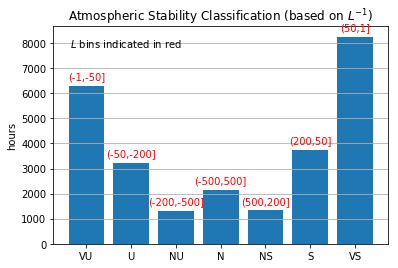

In [17]:
fig,ax = plt.subplots()
counts = ts['stability_zL'].value_counts()[zL_range_names]
ax.bar(zL_range_names, counts)
for i, h in enumerate(counts):
    ax.text(i,h+250,'({:g},{:g}]'.format(Lranges[i],Lranges[i+1]),
            fontdict={'color':'r'},
            horizontalalignment='center')
ax.text(0.05,0.95,'$L$ bins indicated in red', #fontdict={'color':'r'},
        verticalalignment='top', transform=ax.transAxes)
ax.set_ylabel('hours')
ax.grid(axis='y')
ax.set_title('Atmospheric Stability Classification (based on $L^{-1}$)')

fig.savefig(os.path.join(figdir,'Obukhov_stability_classification.png'),bbox_inches='tight',dpi=150)

In [18]:
month = df.index.get_level_values('datetime').month
seasonaldata = {
    'spring': df.loc[(month >= 3) & (month <= 5),:],
    'summer': df.loc[(month >= 6) & (month <= 8),:],
    'fall': df.loc[(month >= 9) & (month <= 11),:],
    'winter': df.loc[(month == 12) | (month <= 2),:],
}

In [19]:
# def get_datetimes_each_year(freq='W'):
#     """args/kwargs for pd.timedelta_range()"""
#     startyear = startanalysis.year
#     endyear = endanalysis.year
#     times_by_season = {
#         'winter': pd.date_range(start=str(startyear-1)+'-12-01', end=str(startyear)+'-02-28', freq=freq),
#         'spring': pd.date_range(start=str(startyear)+'-03-01', end=str(startyear)+'-05-31', freq=freq),
#         'summer': pd.date_range(start=str(startyear)+'-06-01', end=str(startyear)+'-08-30', freq=freq),
#         'fall': pd.date_range(start=str(startyear)+'-09-01', end=str(startyear)+'-11-30', freq=freq),
#     }
#     for year in range(startyear+1,endyear+1):
#         times_by_season['winter'] = times_by_season['winter'].append(pd.date_range(start=str(year-1)+'-12-01', end=str(year)+'-02-28', freq=freq))
#         times_by_season['spring'] = times_by_season['spring'].append(pd.date_range(start=str(year)+'-03-01', end=str(year)+'-05-31', freq=freq))
#         times_by_season['summer'] = times_by_season['summer'].append(pd.date_range(start=str(year)+'-06-01', end=str(year)+'-08-30', freq=freq))
#         times_by_season['fall'] = times_by_season['fall'].append(pd.date_range(start=str(year)+'-09-01', end=str(year)+'-11-30', freq=freq))
#     return times_by_season
# times_by_season = get_datetimes_each_year(freq='W')
# times_by_season

CPU times: user 14.9 s, sys: 497 ms, total: 15.4 s
Wall time: 12.8 s


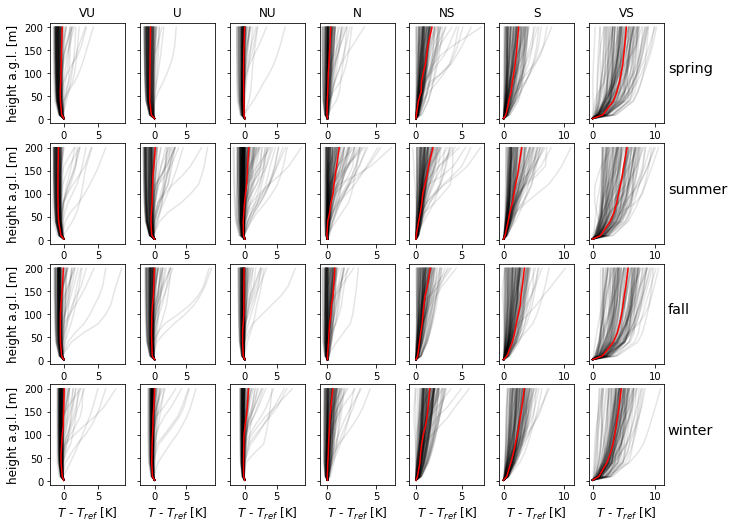

In [44]:
%%time
fig,ax = plt.subplots(nrows=4,ncols=7,sharey=True,figsize=(11,8.5))
Nplot = 100 # approx num of profiles to plot per panel

for irow,(season,data) in enumerate(seasonaldata.items()):
    for icol,stab in enumerate(zL_range_names):
        tmp = data.unstack().loc[ts['stability_zL']==stab,:]
        median = tmp['thetav'].median(axis=0)
        median -= median.loc[zref]
        N = len(tmp)
        tmp = tmp['thetav'].iloc[slice(0,N,int(N/Nplot))]
        for datetime,profile in tmp.iterrows():
            Ttop = profile.loc[zref]
            profile -= Ttop
            ax[irow,icol].plot(profile, profile.index, color='k', alpha=0.1)
        ax[irow,icol].plot(median, median.index, color='r')
    ax[irow,-1].text(1.05, 0.5, season, fontdict={'fontsize':'x-large'}, transform=ax[irow,-1].transAxes)

# make xaxis ranges in each column consistent
for icol in range(len(zL_range_names)):
    allminmax = np.stack([np.array(axi.get_xlim()) for axi in ax[:,icol]])
    minmax = (np.min(allminmax[:,0]), np.max(allminmax[:,1]))
    for axi in ax[:,icol]:
        axi.set_xlim(minmax)

# set labels
for axi in ax[-1,:]:
    axi.set_xlabel('$T$ - $T_{ref}$ [K]',fontsize='large')
for axi in ax[:,0]:
    axi.set_ylabel('height a.g.l. [m]',fontsize='large')
for i,axi in enumerate(ax[0,:]):
    axi.set_title(zL_range_names[i])
    
fig.savefig(os.path.join(figdir, 'thetav_profiles_zLclass.png'),
            bbox_inches='tight', dpi=150)

### - using bulk Richardson number

In [21]:
# Wharton & Lundquist 2012
Ri_ranges = np.array([-np.inf, -0.03, 0.03, np.inf])
Ri_range_names = ['U','N','S']

inrange = (ts['Ri'] >= Ri_ranges[0]) & (ts['Ri'] <= Ri_ranges[-1])
Noutliers = np.count_nonzero(~inrange)
print('{:d} outliers out of {:d} ({:g}%)'.format(Noutliers, len(ts), 100*Noutliers/len(ts)))

0 outliers out of 26304 (0%)


In [22]:
ts['stability_Ri'] = pd.cut(ts['Ri'], bins=Ri_ranges, labels=Ri_range_names)
Ri_ranges

array([ -inf, -0.03,  0.03,   inf])

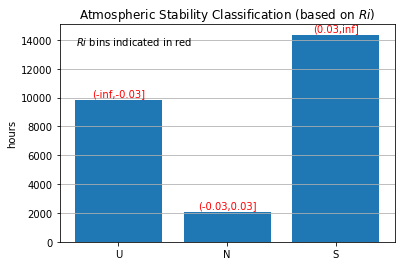

In [23]:
fig,ax = plt.subplots()
counts = ts['stability_Ri'].value_counts()[Ri_range_names]
ax.bar(Ri_range_names, counts)
for i, h in enumerate(counts):
    ax.text(i,h+250,'({:g},{:g}]'.format(Ri_ranges[i],Ri_ranges[i+1]),
            fontdict={'color':'r'},
            horizontalalignment='center')
ax.text(0.05,0.95,'$Ri$ bins indicated in red', #fontdict={'color':'r'},
        verticalalignment='top', transform=ax.transAxes)
ax.set_ylabel('hours')
ax.grid(axis='y')
ax.set_title('Atmospheric Stability Classification (based on $Ri$)')

fig.savefig(os.path.join(figdir,'Richardson_stability_classification.png'),bbox_inches='tight',dpi=150)

CPU times: user 13.2 s, sys: 478 ms, total: 13.7 s
Wall time: 11.1 s


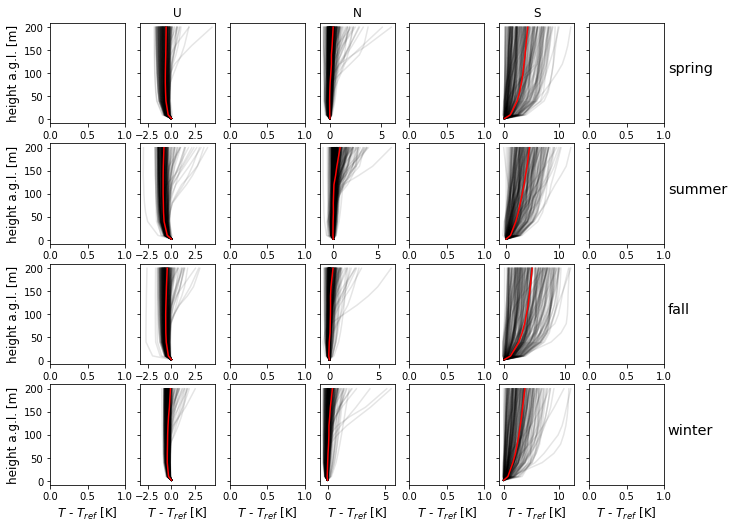

In [45]:
%%time
fig,ax = plt.subplots(nrows=4,ncols=7,sharey=True,figsize=(11,8.5))
#Nplot = 100 # approx num of profiles to plot per panel
Nplot = 200 # approx num of profiles to plot per panel

for irow,(season,data) in enumerate(seasonaldata.items()):
    for icol,stab in enumerate(Ri_range_names):
        tmp = data.unstack().loc[ts['stability_Ri']==stab,:]
        median = tmp['thetav'].median(axis=0)
        median -= median.loc[zref]
        N = len(tmp)
        tmp = tmp['thetav'].iloc[slice(0,N,int(N/Nplot))]
        for datetime,profile in tmp.iterrows():
            Ttop = profile.loc[zref]
            profile -= Ttop
            #ax[irow,icol].plot(profile, profile.index, color='k', alpha=0.1)
            ax[irow,1+2*icol].plot(profile, profile.index, color='k', alpha=0.1)
        ax[irow,1+2*icol].plot(median, median.index, color='r')
    ax[irow,-1].text(1.05, 0.5, season, fontdict={'fontsize':'x-large'}, transform=ax[irow,-1].transAxes)

# make xaxis ranges in each column consistent
for icol in range(len(Ri_range_names)):
    allminmax = np.stack([np.array(axi.get_xlim()) for axi in ax[:,icol]])
    minmax = (np.min(allminmax[:,0]), np.max(allminmax[:,1]))
    for axi in ax[:,icol]:
        axi.set_xlim(minmax)

# set labels
for axi in ax[-1,:]:
    axi.set_xlabel('$T$ - $T_{ref}$ [K]',fontsize='large')
for axi in ax[:,0]:
    axi.set_ylabel('height a.g.l. [m]',fontsize='large')
#for i,axi in enumerate(ax[0,:]):
for i,axi in enumerate(ax[0,1::2]):
    axi.set_title(Ri_range_names[i])
    
fig.savefig(os.path.join(figdir, 'thetav_profiles_Riclass.png'),
            bbox_inches='tight', dpi=150)

### - $z/L$ from bulk $Ri$

In [25]:
zL_from_Ri = ts['Ri'].copy() # unstable: zL == Ri
zL_from_Ri.loc[(ts['Ri'] < -2) | (ts['Ri'] >= 0.2)] = np.nan  # blank outside range of applicability (empirical model from Kansas expt)
sta = (ts['Ri'] > 0) & (ts['Ri'] < 0.2)
Ri_sta = ts.loc[sta,'Ri']
zL_from_Ri.loc[sta] = Ri_sta / (1 - 5*Ri_sta)  # stable: zL = Ri/(1-5Ri)

In [26]:
zL_from_Ri.describe()

count    18279.000000
mean         0.248885
std          5.850237
min         -1.997090
25%         -0.214867
50%         -0.001288
75%          0.175709
max        462.081579
Name: Ri, dtype: float64

In [27]:
inrange = (zL_from_Ri >= zL_ranges[0]) & (zL_from_Ri <= zL_ranges[-1])
Noutliers = np.count_nonzero(~inrange)
print('{:d} outliers out of {:d} ({:g}%)'.format(Noutliers, len(ts), 100*Noutliers/len(ts)))

8536 outliers out of 26304 (32.4513%)


In [28]:
ts['stability_zL_from_Ri'] = pd.cut(zL_from_Ri, bins=zL_ranges, labels=zL_range_names)

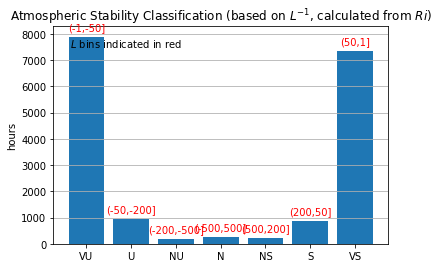

In [29]:
fig,ax = plt.subplots()
counts = ts['stability_zL_from_Ri'].value_counts()[zL_range_names]
ax.bar(zL_range_names, counts)
for i, h in enumerate(counts):
    ax.text(i,h+250,'({:g},{:g}]'.format(Lranges[i],Lranges[i+1]),
            fontdict={'color':'r'},
            horizontalalignment='center')
ax.text(0.05,0.95,'$L$ bins indicated in red', #fontdict={'color':'r'},
        verticalalignment='top', transform=ax.transAxes)
ax.set_ylabel('hours')
ax.grid(axis='y')
ax.set_title('Atmospheric Stability Classification (based on $L^{-1}$, calculated from $Ri$)')

fig.savefig(os.path.join(figdir,'zL_from_Ri_stability_classification.png'),bbox_inches='tight',dpi=150)

CPU times: user 12.7 s, sys: 471 ms, total: 13.2 s
Wall time: 10.6 s


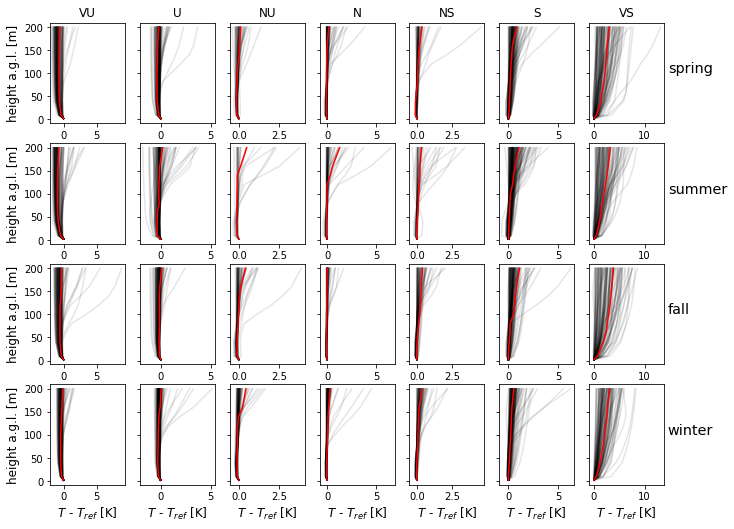

In [46]:
%%time
fig,ax = plt.subplots(nrows=4,ncols=7,sharey=True,figsize=(11,8.5))
Nplot = 100 # approx num of profiles to plot per panel

for irow,(season,data) in enumerate(seasonaldata.items()):
    for icol,stab in enumerate(zL_range_names):
        tmp = data.unstack().loc[ts['stability_zL_from_Ri']==stab,:]
        median = tmp['thetav'].median(axis=0)
        median -= median.loc[zref]
        N = len(tmp)
        skip = max(int(N/Nplot),1)
        tmp = tmp['thetav'].iloc[slice(0,N,skip)]
        for datetime,profile in tmp.iterrows():
            Ttop = profile.loc[zref]
            profile -= Ttop
            ax[irow,icol].plot(profile, profile.index, color='k', alpha=0.1)
        ax[irow,icol].plot(median, median.index, color='r')
    ax[irow,-1].text(1.05, 0.5, season, fontdict={'fontsize':'x-large'}, transform=ax[irow,-1].transAxes)

# make xaxis ranges in each column consistent
for icol in range(len(zL_range_names)):
    allminmax = np.stack([np.array(axi.get_xlim()) for axi in ax[:,icol]])
    minmax = (np.min(allminmax[:,0]), np.max(allminmax[:,1]))
    for axi in ax[:,icol]:
        axi.set_xlim(minmax)

# set labels
for axi in ax[-1,:]:
    axi.set_xlabel('$T$ - $T_{ref}$ [K]',fontsize='large')
for axi in ax[:,0]:
    axi.set_ylabel('height a.g.l. [m]',fontsize='large')
for i,axi in enumerate(ax[0,:]):
    axi.set_title(zL_range_names[i])
    
fig.savefig(os.path.join(figdir, 'thetav_profiles_zLRiclass.png'),
            bbox_inches='tight', dpi=150)

In [49]:
np.count_nonzero(ts['Ri'] > 0.2) / len(ts['Ri'])

0.24213047445255476

#### alternatively...
From Stull, Fig 5.23, in stable regime:
$Ri = \frac{\zeta (0.74 + 4.7\zeta)}{(1+4.7\zeta)^2}$

Solving for $\zeta(Ri)$ gives...

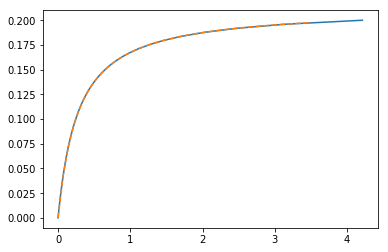

In [31]:
Ri = np.linspace(0,0.2)
x = 0.0212766*(-470*Ri - np.sqrt(12220*Ri + 1369) + 37) / (47*Ri-10)
plt.plot(x,Ri)

x = np.linspace(0,3.5)
Ri = x * (0.74 + 4.7*x) / (1 + 4.7*x)**2
plt.plot(x,Ri,'--')

In [32]:
zL_from_Ri_Stull = ts['Ri'].copy() # unstable: zL == Ri
zL_from_Ri_Stull.loc[(ts['Ri'] < -2) | (ts['Ri'] > 0.2)] = np.nan
sta = (ts['Ri'] > 0) & (ts['Ri'] <= 0.2)  # z/L --> +inf as Ri --> 0.212766
Ri_sta = ts.loc[sta,'Ri']
zL_from_Ri_Stull.loc[sta] = 0.0212766*(-470*Ri_sta - np.sqrt(12220*Ri_sta + 1369) + 37) / (47*Ri_sta-10)

In [33]:
zL_from_Ri_Stull.describe()

count    18279.000000
mean         0.009742
std          0.680920
min         -1.997090
25%         -0.214867
50%         -0.001288
75%          0.216724
max          4.180892
Name: Ri, dtype: float64

In [34]:
inrange = (zL_from_Ri_Stull >= zL_ranges[0]) & (zL_from_Ri_Stull <= zL_ranges[-1])
Noutliers = np.count_nonzero(~inrange)
print('{:d} outliers out of {:d} ({:g}%)'.format(Noutliers, len(ts), 100*Noutliers/len(ts)))

8354 outliers out of 26304 (31.7594%)


In [35]:
ts['stability_zL_from_Ri_Stull'] = pd.cut(zL_from_Ri_Stull, bins=zL_ranges, labels=zL_range_names)

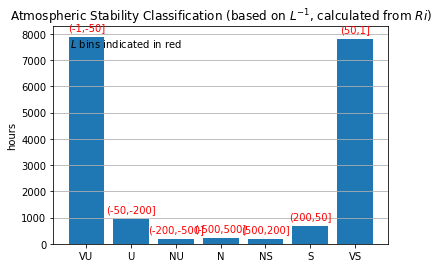

In [36]:
fig,ax = plt.subplots()
counts = ts['stability_zL_from_Ri_Stull'].value_counts()[zL_range_names]
ax.bar(zL_range_names, counts)
for i, h in enumerate(counts):
    ax.text(i,h+250,'({:g},{:g}]'.format(Lranges[i],Lranges[i+1]),
            fontdict={'color':'r'},
            horizontalalignment='center')
ax.text(0.05,0.95,'$L$ bins indicated in red', #fontdict={'color':'r'},
        verticalalignment='top', transform=ax.transAxes)
ax.set_ylabel('hours')
ax.grid(axis='y')
ax.set_title('Atmospheric Stability Classification (based on $L^{-1}$, calculated from $Ri$)')

fig.savefig(os.path.join(figdir,'zL_from_Ri_Stull_stability_classification.png'),bbox_inches='tight',dpi=150)

CPU times: user 12.1 s, sys: 430 ms, total: 12.6 s
Wall time: 10.1 s


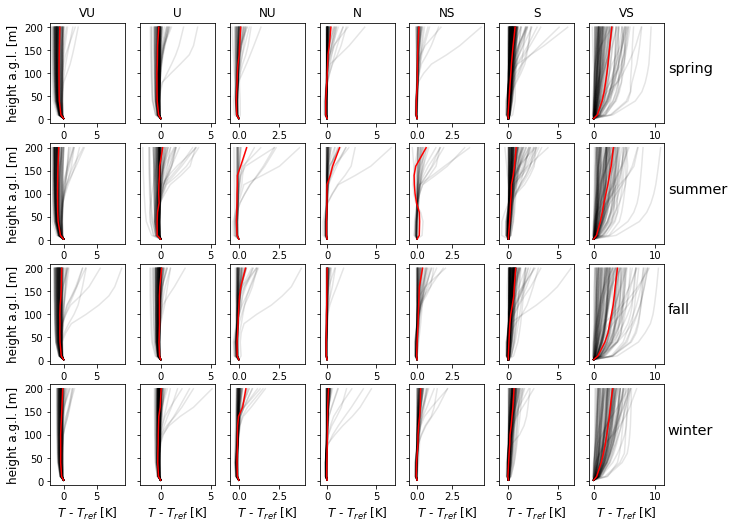

In [47]:
%%time
fig,ax = plt.subplots(nrows=4,ncols=7,sharey=True,figsize=(11,8.5))
Nplot = 100 # approx num of profiles to plot per panel

for irow,(season,data) in enumerate(seasonaldata.items()):
    for icol,stab in enumerate(zL_range_names):
        tmp = data.unstack().loc[ts['stability_zL_from_Ri_Stull']==stab,:]
        median = tmp['thetav'].median(axis=0)
        median -= median.loc[zref]
        N = len(tmp)
        skip = max(int(N/Nplot),1)
        tmp = tmp['thetav'].iloc[slice(0,N,skip)]
        for datetime,profile in tmp.iterrows():
            Ttop = profile.loc[zref]
            profile -= Ttop
            ax[irow,icol].plot(profile, profile.index, color='k', alpha=0.1)
        ax[irow,icol].plot(median, median.index, color='r')
    ax[irow,-1].text(1.05, 0.5, season, fontdict={'fontsize':'x-large'}, transform=ax[irow,-1].transAxes)

# make xaxis ranges in each column consistent
for icol in range(len(zL_range_names)):
    allminmax = np.stack([np.array(axi.get_xlim()) for axi in ax[:,icol]])
    minmax = (np.min(allminmax[:,0]), np.max(allminmax[:,1]))
    for axi in ax[:,icol]:
        axi.set_xlim(minmax)

# set labels
for axi in ax[-1,:]:
    axi.set_xlabel('$T$ - $T_{ref}$ [K]',fontsize='large')
for axi in ax[:,0]:
    axi.set_ylabel('height a.g.l. [m]',fontsize='large')
for i,axi in enumerate(ax[0,:]):
    axi.set_title(zL_range_names[i])
    
fig.savefig(os.path.join(figdir, 'thetav_profiles_zLRiStullclass.png'),
            bbox_inches='tight', dpi=150)

In [39]:
tmp

height,2.0,10.0,40.0,60.0,80.0,100.0,120.0,140.0,160.0,200.0
datetime,,,,,,,,,,
2011-01-01 09:00:00,257.857903,258.116924,258.493708,258.672488,258.836438,258.985516,259.114760,259.241484,259.346968,259.518958
2011-01-03 01:00:00,265.651444,266.604122,267.456771,267.714352,267.903659,268.046495,268.180108,268.298555,268.411236,268.619392
2011-01-05 04:00:00,265.119197,266.303336,267.792945,268.371780,268.835891,269.203584,269.549566,269.884043,270.286349,271.095174
2011-01-06 16:00:00,274.491346,274.879497,275.456577,275.748775,276.019774,276.228107,276.386033,276.471257,276.486719,276.419750
2011-01-08 15:00:00,274.881394,275.420222,276.240684,276.607284,276.914158,277.157804,277.369562,277.553055,277.675874,277.813115
2011-01-13 09:00:00,271.232840,272.078382,273.073380,273.534279,273.952294,274.314375,274.628931,274.903016,275.123627,275.506377
2011-01-14 21:00:00,277.580281,277.817367,278.140343,278.282708,278.412858,278.495255,278.565556,278.597517,278.604042,278.585813
2011-01-16 17:00:00,276.764260,277.008079,277.357256,277.532099,277.694799,277.838845,277.977128,278.106343,278.226459,278.439268
2011-01-17 23:00:00,275.367216,275.664614,276.097791,276.371801,276.653470,277.106128,277.559813,278.068052,278.298690,278.505472
